##### **Importing Libraries**

In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")


##### **Downloading dataset and extraction**

In [ ]:
import os
import subprocess
from zipfile import ZipFile

def fetch_aptos2019(save_dir="/content/aptos2019", zip_name="aptos2019.zip"):
    os.makedirs(save_dir, exist_ok=True)
    zip_file = os.path.join(save_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_file,
        "https://www.kaggle.com/api/v1/datasets/download/mariaherrerot/aptos2019"
    ], check=True)

    with ZipFile(zip_file, "r") as z:
        z.extractall(os.path.join(save_dir, "dataset"))

    print("Downloaded and extracted at:", os.path.join(save_dir, "dataset"))

fetch_aptos2019()


Downloaded and extracted at: /content/aptos2019/dataset


###### **Loading CSV files**

In [ ]:
train_data = pd.read_csv("/content/aptos2019/dataset/train_1.csv")
valid_data = pd.read_csv("/content/aptos2019/dataset/valid.csv")
test_data = pd.read_csv("/content/aptos2019/dataset/test.csv")

print(train_data.shape, valid_data.shape, test_data.shape)


(2930, 2) (366, 2) (366, 2)


##### **Directory Checks**

In [ ]:
train_image_dir = "/content/aptos2019/dataset/train_images/train_images"
val_image_dir = "/content/aptos2019/dataset/val_images/val_images"
test_image_dir = "/content/aptos2019/dataset/test_images/test_images"

def count_images(path):
    return len([i for i in os.listdir(path) if i.endswith(('.png','.jpg','.jpeg'))])

print(count_images(train_image_dir), count_images(val_image_dir), count_images(test_image_dir))


2930 366 366


##### **Sample Images**

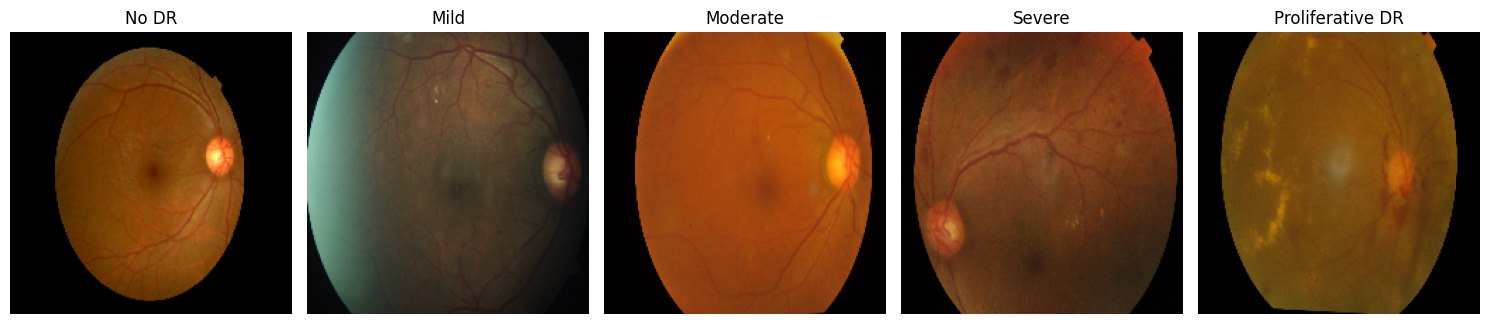

In [ ]:
labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

unique_ids = []
for c in range(5):
    img_id = train_data[train_data['diagnosis'] == c]['id_code'].iloc[0]
    unique_ids.append((img_id, c))

plt.figure(figsize=(15, 4))
for i, (img_id, c) in enumerate(unique_ids):
    img = load_img(os.path.join(train_image_dir, f"{img_id}.png"), target_size=(200,200))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(labels[c], fontsize=12)

plt.tight_layout()
plt.show()


##### **Class Distribution**

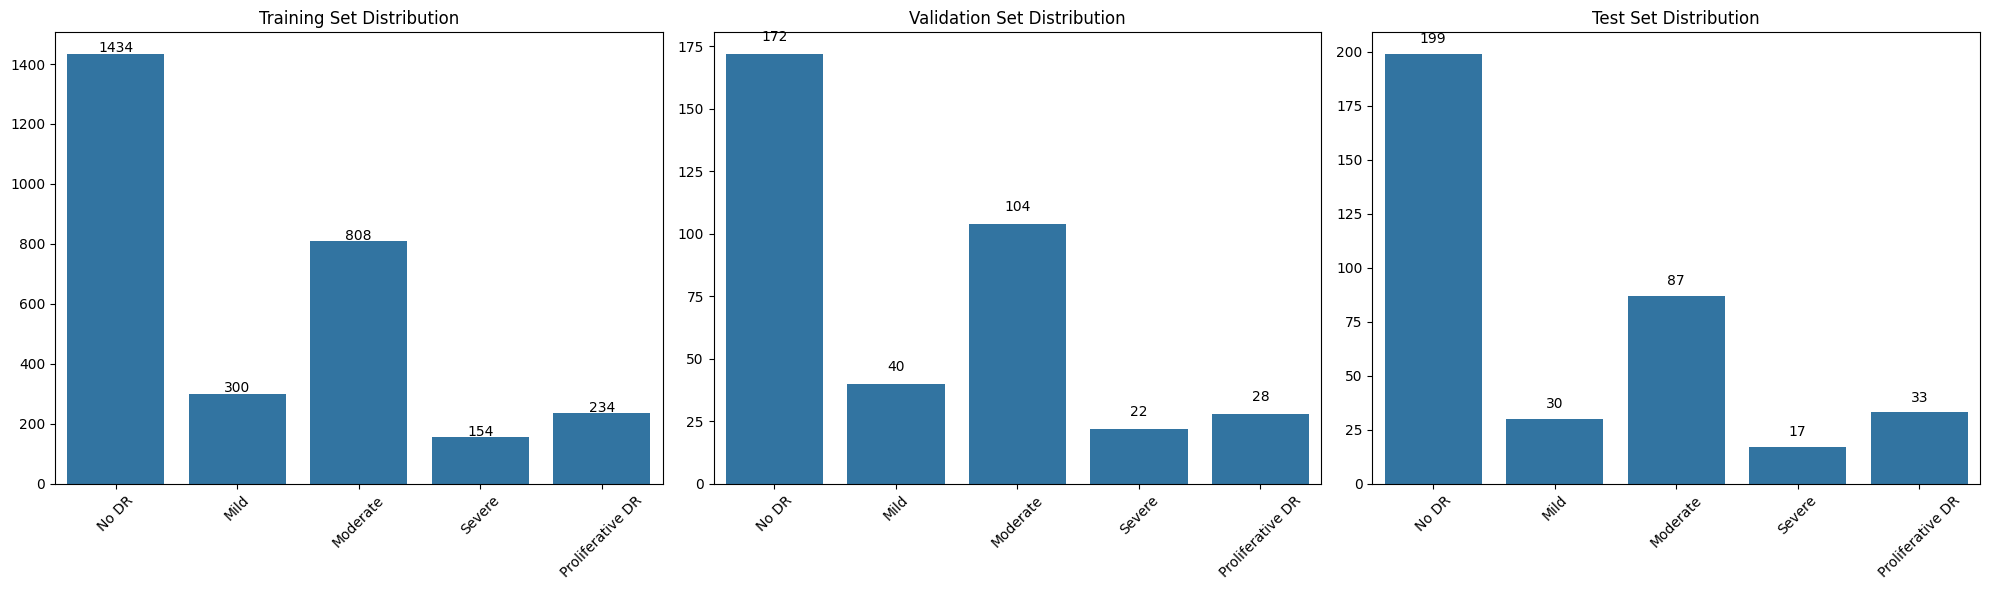

In [ ]:
label_map = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

train_counts = train_data['diagnosis'].value_counts().sort_index()
val_counts = valid_data['diagnosis'].value_counts().sort_index()
test_counts = test_data['diagnosis'].value_counts().sort_index()

train_labels = [label_map[i] for i in train_counts.index]
val_labels   = [label_map[i] for i in val_counts.index]
test_labels  = [label_map[i] for i in test_counts.index]

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
ax = sns.barplot(x=train_labels, y=train_counts.values)
for i, v in enumerate(train_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Training Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,2)
ax = sns.barplot(x=val_labels, y=val_counts.values)
for i, v in enumerate(val_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Validation Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,3)
ax = sns.barplot(x=test_labels, y=test_counts.values)
for i, v in enumerate(test_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Test Set Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


##### **Dimension Distributions**

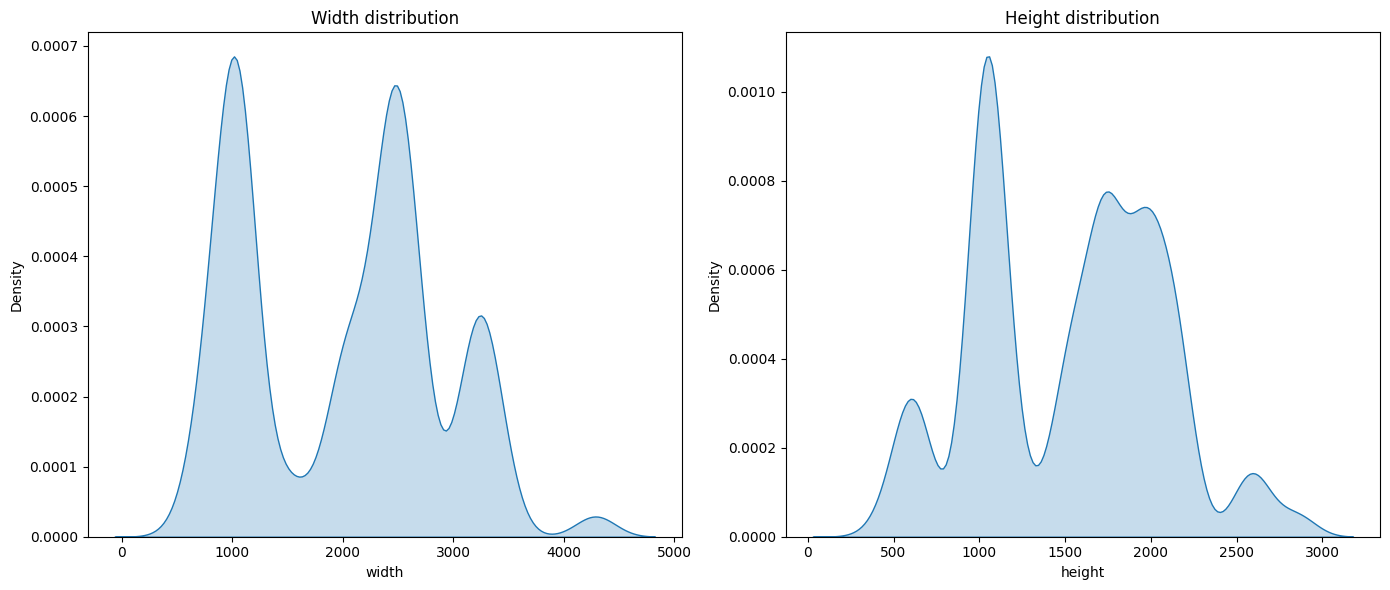

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

sizes = []

for img_id in train_data['id_code']:
    path = os.path.join(train_image_dir, f"{img_id}.png")
    if os.path.exists(path):
        w, h = Image.open(path).size
        sizes.append([img_id, w, h])

df_dims = pd.DataFrame(sizes, columns=["id_code", "width", "height"])
df_dims.head()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.kdeplot(df_dims['width'], fill=True)
plt.title("Width distribution")

plt.subplot(1,2,2)
sns.kdeplot(df_dims['height'], fill=True)
plt.title("Height distribution")

plt.tight_layout()
plt.show()


**Preprocessing + (Data Upsampling) SMOTE**

In [ ]:
IMG_SIZE = 100

def preprocess(idc):
    img = load_img(os.path.join(train_image_dir, f"{idc}.png"), target_size=(IMG_SIZE,IMG_SIZE))
    return img_to_array(img)/255.0

X = np.array([preprocess(i) for i in train_data['id_code']])
y = train_data['diagnosis'].values

sm = SMOTE(random_state=42)
Xr, yr = sm.fit_resample(X.reshape(X.shape[0], -1), y)
Xr = Xr.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
yr = to_categorical(yr, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(Xr, yr, test_size=0.2, random_state=42)


##### **Data distribution after upsampling**

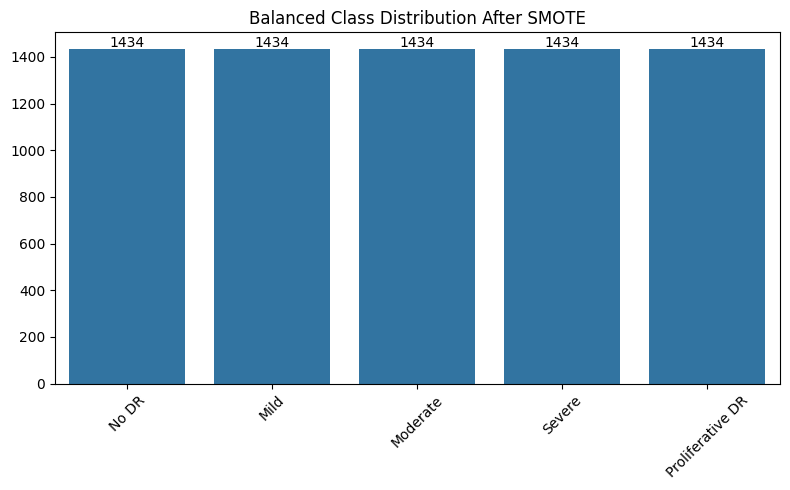

In [ ]:
yr_classes = np.argmax(yr, axis=1)
yr_counts = pd.Series(yr_classes).value_counts().sort_index()

labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}
yr_labels = [labels[i] for i in yr_counts.index]

plt.figure(figsize=(8,5))
ax = sns.barplot(x=yr_labels, y=yr_counts.values)
for i,v in enumerate(yr_counts.values):
    ax.text(i, v + 10, str(v), ha='center')
plt.title("Balanced Class Distribution After SMOTE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### **CNN Model**

In [ ]:
def make_model(input_shape):
    m = Sequential()
    m.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
    m.add(MaxPooling2D(2,2))
    m.add(Conv2D(64,(3,3),activation='relu'))
    m.add(MaxPooling2D(2,2))
    m.add(Conv2D(128,(3,3),activation='relu'))
    m.add(MaxPooling2D(2,2))
    m.add(Flatten())
    m.add(Dense(128,activation='relu'))
    m.add(Dropout(0.5))
    m.add(Dense(5,activation='softmax'))
    return m


##### **Hyperparameter tuning of learning rate and Training**

In [ ]:
lrs = [1e-4, 3e-4, 1e-3]
best_lr = None
best_acc = -1
best_history = None
best_model = None

for lr in lrs:
    model = make_model((IMG_SIZE,IMG_SIZE,3))
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
    cp = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val,y_val),
        epochs=40,
        batch_size=32,
        callbacks=[es,cp],
        verbose=1
    )

    acc = max(history.history['val_accuracy'])
    if acc > best_acc:
        best_acc = acc
        best_lr = lr
        best_model = model
        best_history = history

print("Best LR:", best_lr)
print("Best Val Accuracy:", best_acc)


Epoch 1/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - accuracy: 0.4698 - loss: 1.3482 - val_accuracy: 0.3661 - val_loss: 1.8950
Epoch 2/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8116 - loss: 0.5376 - val_accuracy: 0.3696 - val_loss: 2.5732
Epoch 3/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9300 - loss: 0.2121 - val_accuracy: 0.3417 - val_loss: 3.1255
Epoch 4/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9722 - loss: 0.0979 - val_accuracy: 0.4575 - val_loss: 2.7730
Epoch 5/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9899 - loss: 0.0440 - val_accuracy: 0.4916 - val_loss: 2.5497
Epoch 6/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9970 - loss: 0.0196 - val_accuracy: 0.5042 - val_loss: 3.1764
Epoch 7/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9862 - loss: 0.0476 - val_accuracy: 0.4944 - val_loss: 3.4260
Epoch 8/40
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9910 - loss: 0.0319 - val_ac

##### **Best Parameters and Validation score**

In [ ]:
print("Best LR:", best_lr)
print("Best Val Accuracy:", best_acc)

Best LR: 0.0001
Best Val Accuracy: 0.9553695917129517


##### **Training accuracy and loss plots**

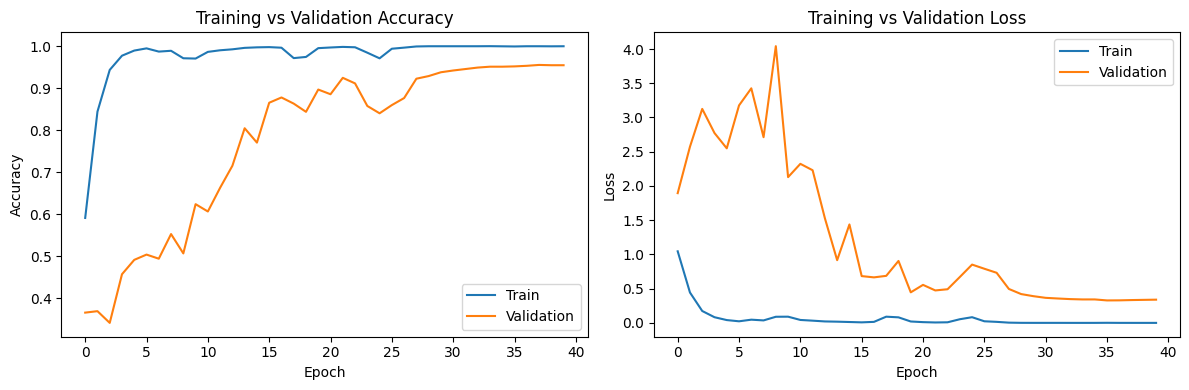

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.tight_layout()
plt.show()


##### **Confusion matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


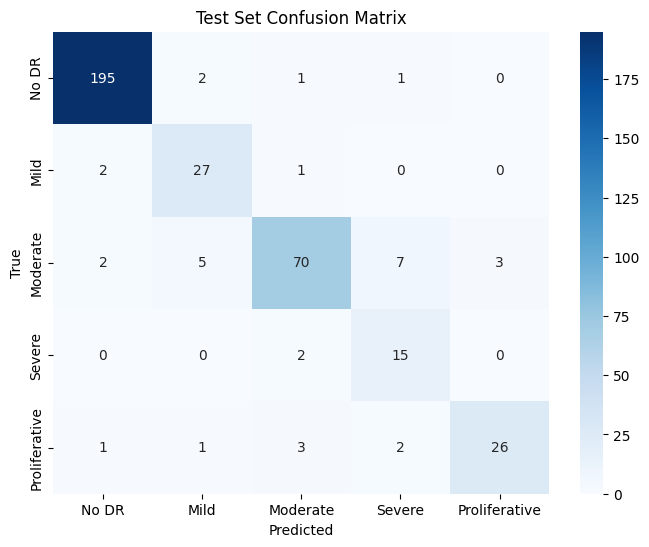

Test Set Classification Report:
               precision    recall  f1-score   support

        No DR       0.97      0.98      0.98       199
         Mild       0.77      0.90      0.83        30
     Moderate       0.91      0.80      0.85        87
       Severe       0.60      0.88      0.71        17
Proliferative       0.90      0.79      0.84        33

     accuracy                           0.91       366
    macro avg       0.83      0.87      0.84       366
 weighted avg       0.92      0.91      0.91       366



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_image_dir = "/content/aptos2019/dataset/test_images/test_images"

labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]

def preprocess_test(idc):
    path = os.path.join(test_image_dir, f"{idc}.png")
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    return img_to_array(img) / 255.0

valid_ids = []
valid_labels = []

for i, row in test_data.iterrows():
    img_path = os.path.join(test_image_dir, f"{row['id_code']}.png")
    if os.path.exists(img_path):
        valid_ids.append(row['id_code'])
        valid_labels.append(row['diagnosis'])

Xt = np.array([preprocess_test(i) for i in valid_ids])
yt = np.array(valid_labels)
yt_cat = to_categorical(yt, num_classes=5)

pred_test = best_model.predict(Xt)
pred_test_cls = np.argmax(pred_test, 1)
true_test_cls = np.argmax(yt_cat, 1)

cm_test = confusion_matrix(true_test_cls, pred_test_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()

print("Test Set Classification Report:")
print(classification_report(true_test_cls, pred_test_cls))


##### **Transfer Learning**

##### **MobileNetV2**

In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
warnings.filterwarnings("ignore")


In [ ]:
import os
import subprocess
from zipfile import ZipFile

def fetch_aptos2019(save_dir="/content/aptos2019", zip_name="aptos2019.zip"):
    os.makedirs(save_dir, exist_ok=True)
    zip_file = os.path.join(save_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_file,
        "https://www.kaggle.com/api/v1/datasets/download/mariaherrerot/aptos2019"
    ], check=True)

    with ZipFile(zip_file, "r") as z:
        z.extractall(os.path.join(save_dir, "dataset"))

    print("Downloaded and extracted at:", os.path.join(save_dir, "dataset"))

fetch_aptos2019()


Downloaded and extracted at: /content/aptos2019/dataset


###### **Loading CSV files**

In [ ]:
train_data = pd.read_csv("/content/aptos2019/dataset/train_1.csv")
valid_data = pd.read_csv("/content/aptos2019/dataset/valid.csv")
test_data = pd.read_csv("/content/aptos2019/dataset/test.csv")

print(train_data.shape, valid_data.shape, test_data.shape)


(2930, 2) (366, 2) (366, 2)


##### **Directory Checks**

In [ ]:
train_image_dir = "/content/aptos2019/dataset/train_images/train_images"
val_image_dir = "/content/aptos2019/dataset/val_images/val_images"
test_image_dir = "/content/aptos2019/dataset/test_images/test_images"

def count_images(path):
    return len([i for i in os.listdir(path) if i.endswith(('.png','.jpg','.jpeg'))])

print(count_images(train_image_dir), count_images(val_image_dir), count_images(test_image_dir))


2930 366 366


##### **Sample Images**

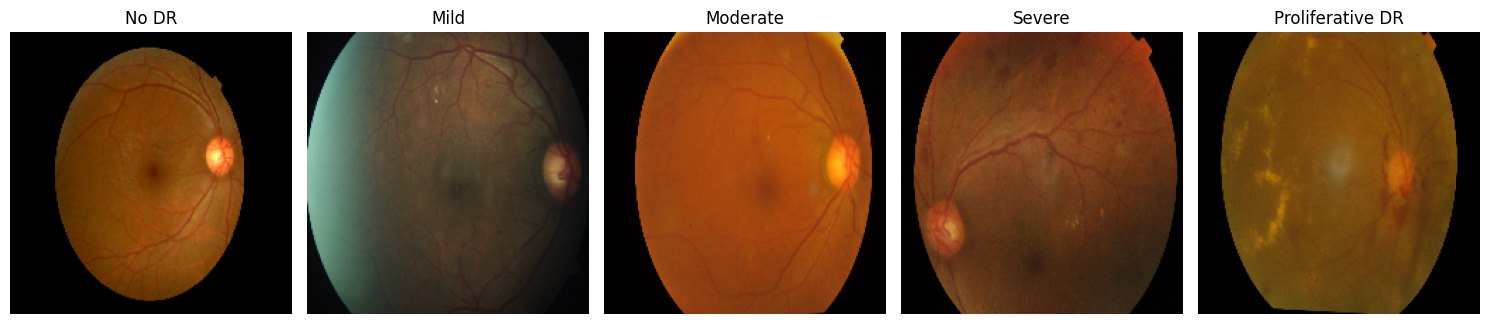

In [ ]:
labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

unique_ids = []
for c in range(5):
    img_id = train_data[train_data['diagnosis'] == c]['id_code'].iloc[0]
    unique_ids.append((img_id, c))

plt.figure(figsize=(15, 4))
for i, (img_id, c) in enumerate(unique_ids):
    img = load_img(os.path.join(train_image_dir, f"{img_id}.png"), target_size=(200,200))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(labels[c], fontsize=12)

plt.tight_layout()
plt.show()


##### **Class Distribution**

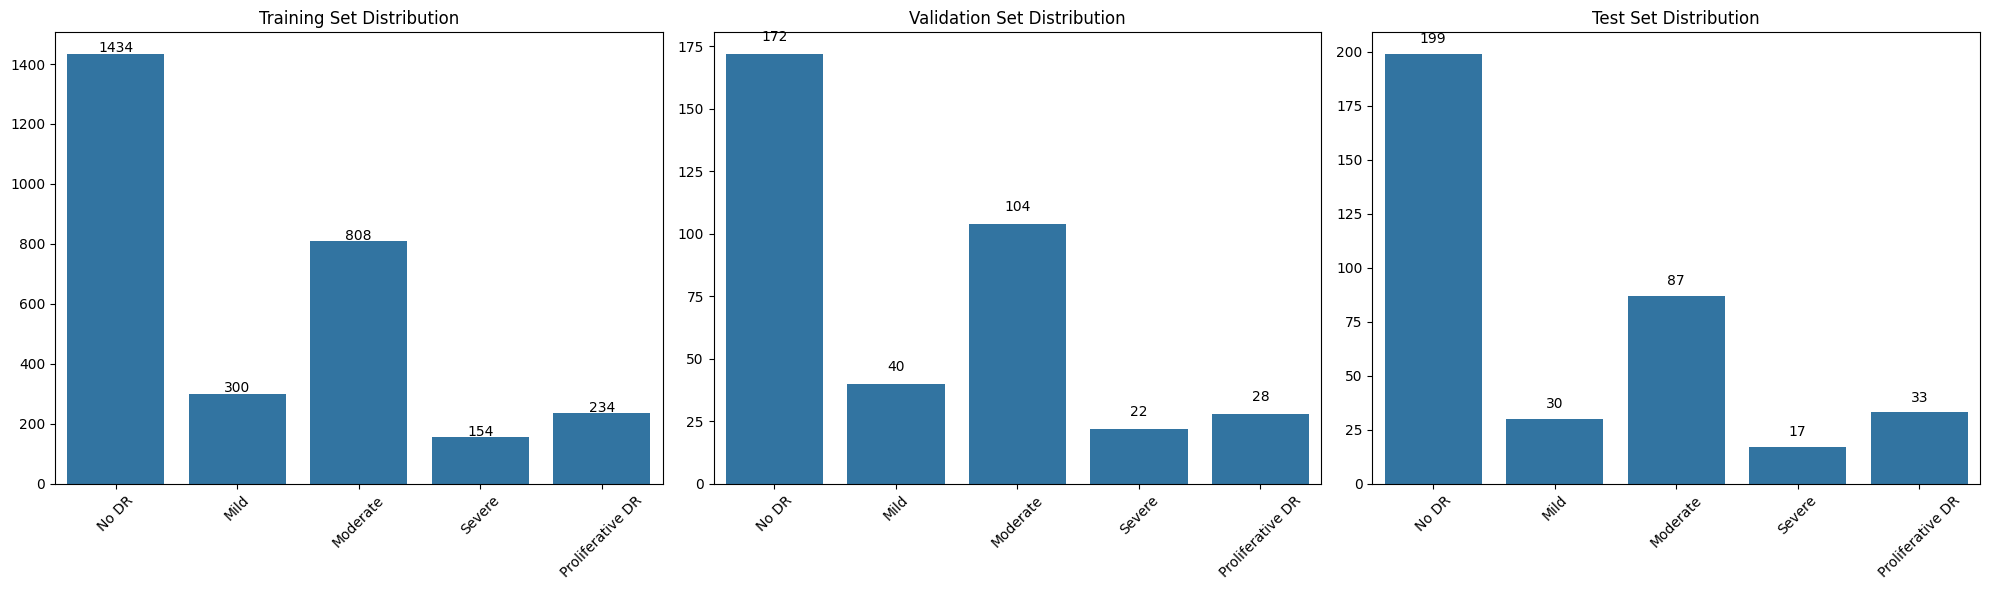

In [ ]:
label_map = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

train_counts = train_data['diagnosis'].value_counts().sort_index()
val_counts = valid_data['diagnosis'].value_counts().sort_index()
test_counts = test_data['diagnosis'].value_counts().sort_index()

train_labels = [label_map[i] for i in train_counts.index]
val_labels   = [label_map[i] for i in val_counts.index]
test_labels  = [label_map[i] for i in test_counts.index]

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
ax = sns.barplot(x=train_labels, y=train_counts.values)
for i, v in enumerate(train_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Training Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,2)
ax = sns.barplot(x=val_labels, y=val_counts.values)
for i, v in enumerate(val_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Validation Set Distribution")
plt.xticks(rotation=45)

plt.subplot(1,3,3)
ax = sns.barplot(x=test_labels, y=test_counts.values)
for i, v in enumerate(test_counts.values):
    ax.text(i, v + 5, str(v), ha='center')
plt.title("Test Set Distribution")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


##### **Dimension Distributions**

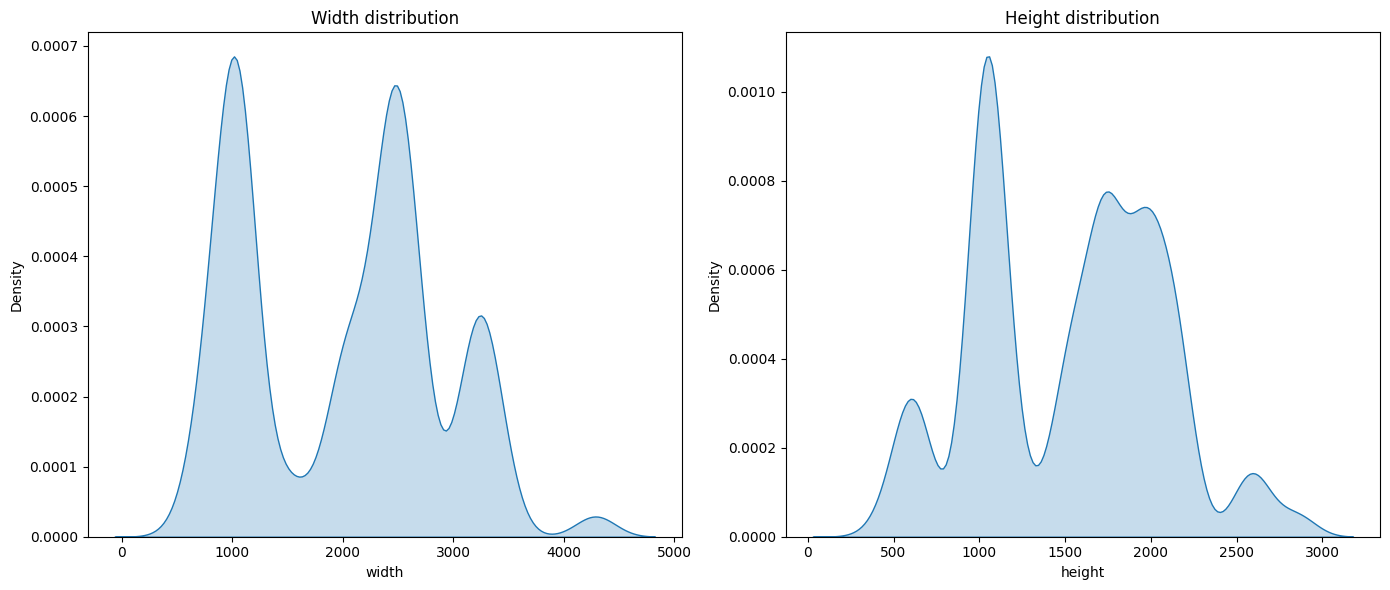

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

sizes = []

for img_id in train_data['id_code']:
    path = os.path.join(train_image_dir, f"{img_id}.png")
    if os.path.exists(path):
        w, h = Image.open(path).size
        sizes.append([img_id, w, h])

df_dims = pd.DataFrame(sizes, columns=["id_code", "width", "height"])
df_dims.head()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.kdeplot(df_dims['width'], fill=True)
plt.title("Width distribution")

plt.subplot(1,2,2)
sns.kdeplot(df_dims['height'], fill=True)
plt.title("Height distribution")

plt.tight_layout()
plt.show()


**Preprocessing + (Data Upsampling) SMOTE**

In [ ]:
IMG_SIZE = 100

def preprocess(idc):
    img = load_img(os.path.join(train_image_dir, f"{idc}.png"), target_size=(IMG_SIZE,IMG_SIZE))
    return img_to_array(img)/255.0

X = np.array([preprocess(i) for i in train_data['id_code']])
y = train_data['diagnosis'].values

sm = SMOTE(random_state=42)
Xr, yr = sm.fit_resample(X.reshape(X.shape[0], -1), y)
Xr = Xr.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
yr = to_categorical(yr, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(Xr, yr, test_size=0.2, random_state=42)


##### **Data distribution after upsampling**

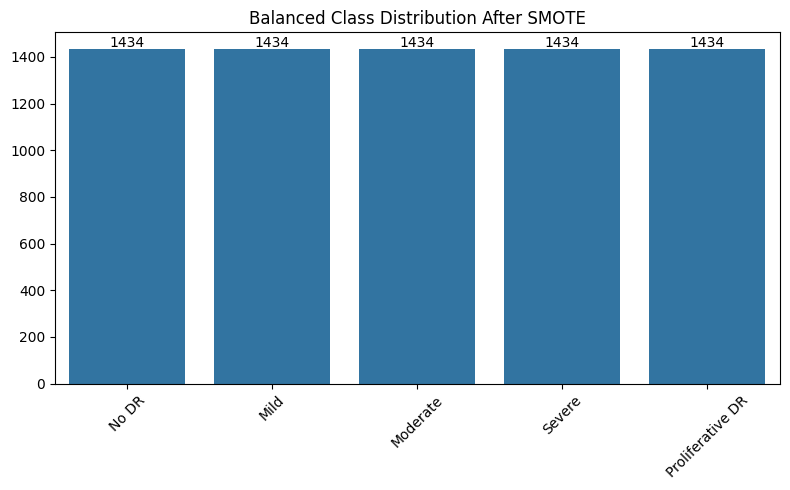

In [ ]:
yr_classes = np.argmax(yr, axis=1)
yr_counts = pd.Series(yr_classes).value_counts().sort_index()

labels = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}
yr_labels = [labels[i] for i in yr_counts.index]

plt.figure(figsize=(8,5))
ax = sns.barplot(x=yr_labels, y=yr_counts.values)
for i,v in enumerate(yr_counts.values):
    ax.text(i, v + 10, str(v), ha='center')
plt.title("Balanced Class Distribution After SMOTE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### **MobileNetV2 Model building**  

In [ ]:
def make_model(input_shape):
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights="imagenet")
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(5, activation='softmax')(x)
    model = Model(base.input, out)
    return model


##### **MobileNetV2 Model Training**  

In [ ]:
lrs = [1e-5, 3e-5, 1e-4]
best_lr = None
best_acc = -1
best_history = None
best_model = None

for lr in lrs:
    model = make_model((IMG_SIZE,IMG_SIZE,3))
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
    cp = ModelCheckpoint('best_mobilenetv2.keras', save_best_only=True, monitor='val_accuracy')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val,y_val),
        epochs=25,
        batch_size=32,
        callbacks=[es,cp],
        verbose=1
    )

    acc = max(history.history['val_accuracy'])
    if acc > best_acc:
        best_acc = acc
        best_lr = lr
        best_model = model
        best_history = history

print("Best LR:", best_lr)
print("Best Val Accuracy:", best_acc)


Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2558 - loss: 1.8401

I0000 00:00:1763900113.894095     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 56 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



180/180 ━━━━━━━━━━━━━━━━━━━━ 65s 156ms/step - accuracy: 0.2561 - loss: 1.8393 - val_accuracy: 0.3271 - val_loss: 1.6834
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4877 - loss: 1.2672 - val_accuracy: 0.3452 - val_loss: 1.6195
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6006 - loss: 1.0249 - val_accuracy: 0.3591 - val_loss: 1.5567
Epoch 4/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6854 - loss: 0.8584 - val_accuracy: 0.3863 - val_loss: 1.4965
Epoch 5/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7507 - loss: 0.7136 - val_accuracy: 0.4212 - val_loss: 1.4221
Epoch 6/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8046 - loss: 0.6046 - val_accuracy: 0.4351 - val_loss: 1.3659
Epoch 7/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8342 - loss: 0.5137 - val_accuracy: 0.4630 - val_loss: 1.3135
Epoch 8/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8801 - loss: 0.4192 - val_accuracy: 0.4

##### **Mobile1netV2 Training and Validation Plots**

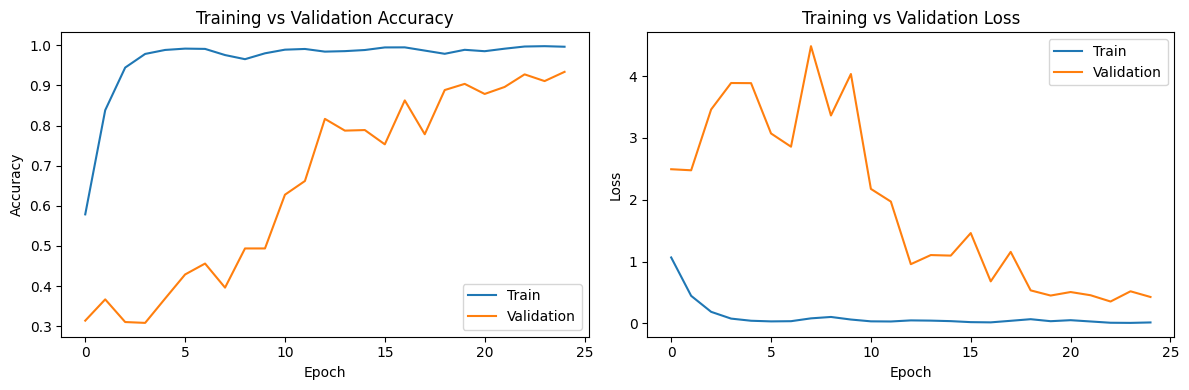

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.tight_layout()
plt.show()


##### **MobileNetV2 Evaluation**

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


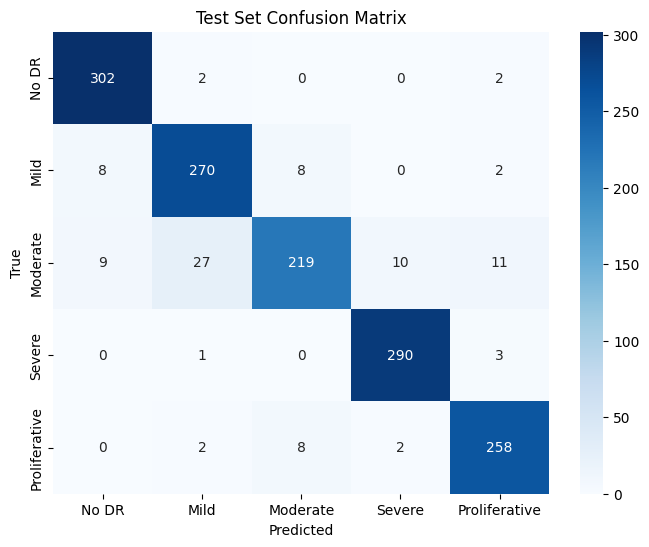

Test Set Classification Report:
               precision    recall  f1-score   support

        No DR       0.95      0.99      0.97       306
         Mild       0.89      0.94      0.92       288
     Moderate       0.93      0.79      0.86       276
       Severe       0.96      0.99      0.97       294
Proliferative       0.93      0.96      0.95       270

     accuracy                           0.93      1434
    macro avg       0.93      0.93      0.93      1434
 weighted avg       0.93      0.93      0.93      1434



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_image_dir = "/content/aptos2019/dataset/test_images/test_images"

labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]

def preprocess_test(idc):
    path = os.path.join(test_image_dir, f"{idc}.png")
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    return img_to_array(img) / 255.0

valid_ids = []
valid_labels = []

for i, row in test_data.iterrows():
    img_path = os.path.join(test_image_dir, f"{row['id_code']}.png")
    if os.path.exists(img_path):
        valid_ids.append(row['id_code'])
        valid_labels.append(row['diagnosis'])

Xt = np.array([preprocess_test(i) for i in valid_ids])
yt = np.array(valid_labels)
yt_cat = to_categorical(yt, num_classes=5)

pred_test = best_model.predict(Xt)
pred_test_cls = np.argmax(pred_test, 1)
true_test_cls = np.argmax(yt_cat, 1)

cm_test = confusion_matrix(true_test_cls, pred_test_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()

print("Test Set Classification Report:")
print(classification_report(true_test_cls, pred_test_cls))
